# Self-Driving Car Engineer Nanodegree

### Project: Advanced Lane Finding

In [1]:
#importing some useful packages
# Import everything needed to edit/save/watch video clips

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
def plot_output(name_str, image): 
    plt.imshow(image)
    plt.title(name_str)
    plt.show()

## Calibrating camera

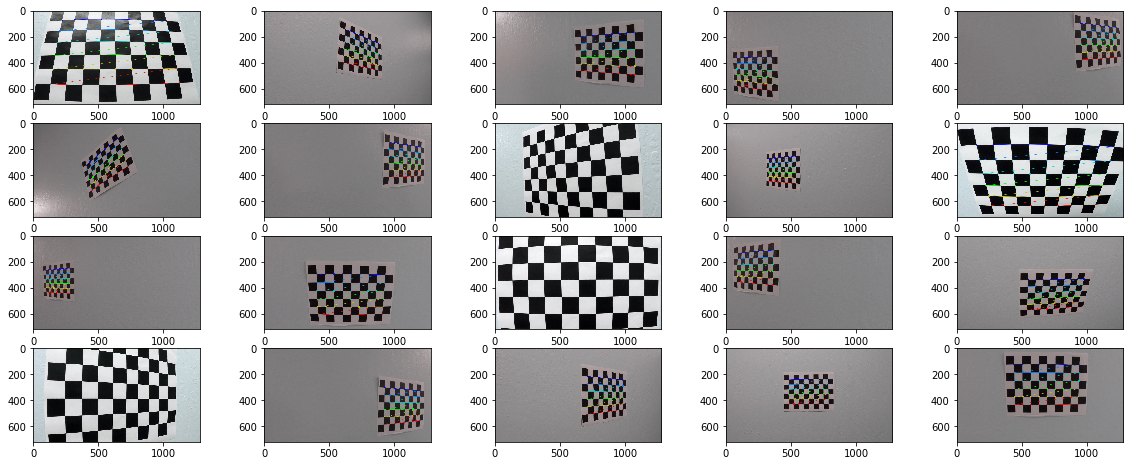

In [3]:
images = [cv2.imread(file) for file in glob.glob("camera_cal/*.jpg")]

nx = 9
ny = 6

objpoints = []
imgpoints = []

for n in range(0, len(images)):
    gray = cv2.cvtColor(images[n], cv2.COLOR_BGR2GRAY)
    
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
    # Draw and display the corners
        cv2.drawChessboardCorners(images[n], (nx, ny), corners, ret)
               
        objpoints.append(objp)
        imgpoints.append(corners)

plt.figure(figsize=(20,10))
plt.title("Undistorted Chessboard Images")
columns = 5
for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)        
        plt.imshow(image)



...


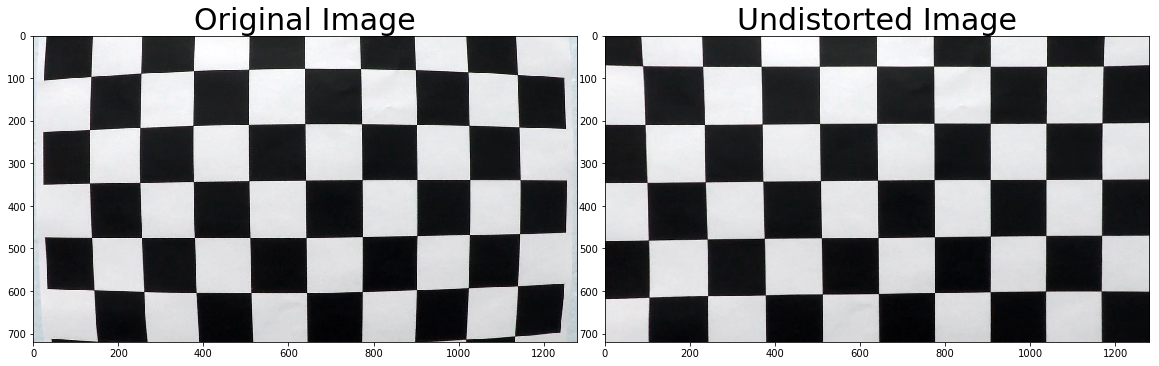

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('...')

### Example Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


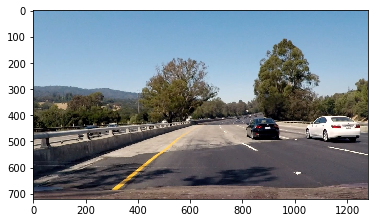

In [5]:
exampleImg = mpimg.imread('test_images/test4.jpg')

#printing out some stats and plotting
print('This image is:', type(exampleImg), 'with dimensions:', exampleImg.shape)
plt.imshow(exampleImg)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#### lets see how much we undistort our image

In [6]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

...


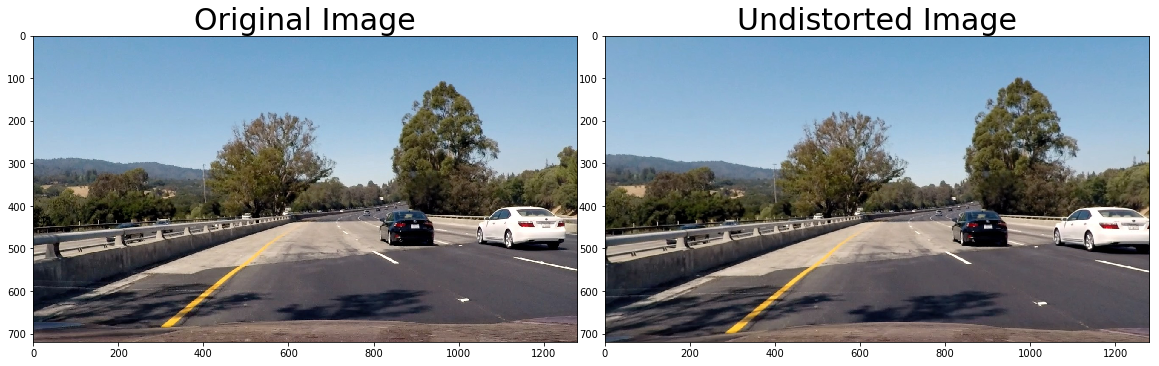

In [7]:
ex_undistort = cal_undistort(exampleImg, objpoints, imgpoints)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(ex_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

print('...')

#### undistortion is noticeable in shape of car hood

## Perspective Transform (Bird-eye-view)

In [8]:
# set roi before Perspective Transform

def region_of_interest(img, vertices= np.array([[[0, 0],\
                                                 [img.shape[1],0],\
                                                 [img.shape[1]*0.79,img.shape[0]],\
                                                 [img.shape[1]*0.20,img.shape[0]]]],np.int32)):
    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [9]:
def bird_eye_view(img, arr_vertices = np.array([[[img.shape[1]*0.451, img.shape[0]*0.625],\
                                                 [img.shape[1]*0.554,img.shape[0]*0.625],\
                                                 [img.shape[1]*1,img.shape[0]],\
                                                 [img.shape[1]*0.05,img.shape[0]]]],np.int32)):

    src = np.float32([[arr_vertices[0,0,0]-50,arr_vertices[0,0,1]],\
                      [arr_vertices[0,1,0]+50,arr_vertices[0,1,1]],\
                      [arr_vertices[0,3,0]-500,arr_vertices[0,3,1]],\
                      [arr_vertices[0,2,0]+500,arr_vertices[0,2,1]]])
    
    dst = np.float32([[0.,0.],[img.shape[1],0.],[0.,img.shape[0]],[img.shape[1],img.shape[0]]])
        
    img_size = (img.shape[1], img.shape[0])
    
    minv = cv2.getPerspectiveTransform(src, dst)
    
    
    warped = cv2.warpPerspective(img, minv, img_size,flags=cv2.INTER_LINEAR)
    
    return warped

...


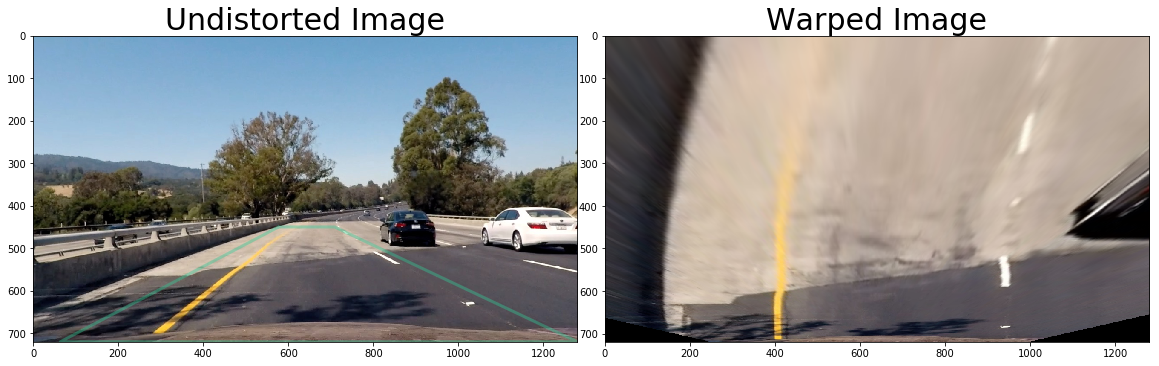

In [10]:
h,w = ex_undistort.shape[:2]

arr_vertices = np.array([[[img.shape[1]*0.451, img.shape[0]*0.625],\
                          [img.shape[1]*0.554,img.shape[0]*0.625],\
                          [img.shape[1]*1,img.shape[0]],\
                          [img.shape[1]*0.05,img.shape[0]]]],np.int32)

#ex_roi = region_of_interest(ex_undistort,arr_vertices)
ex_warp = bird_eye_view(ex_undistort)


# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(ex_undistort)

# roi_img points => non_black pixels in Unwarped Image
src = np.float32([[arr_vertices[0,0,0],arr_vertices[0,0,1]],\
                  [arr_vertices[0,1,0],arr_vertices[0,1,1]],\
                  [arr_vertices[0,3,0],arr_vertices[0,3,1]],\
                  [arr_vertices[0,2,0],arr_vertices[0,2,1]]])


x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(ex_warp)
ax2.set_title('Warped Image', fontsize=30)

print('...')

## Binary image creation

In [11]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [12]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [13]:
def update(min_thresh, max_thresh):
    ex_sobelAbs = abs_sobel_thresh(ex_warp, 'x',None ,(min_thresh,max_thresh))
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(ex_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=30)

interact(update, 
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


In [14]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [15]:
def update(kernel_size, min_thresh, max_thresh):
    ex_sobelMag = mag_thresh(ex_warp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(ex_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255))

print('...')

interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


In [16]:
def dir_thresh(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [17]:
def update(kernel_size, min_thresh, max_thresh):
    ex_sobelDir = dir_thresh(ex_warp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(ex_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))

print('...')

interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), FloatSlider(value=0.78, description='min_thresh', max=1.5707963267948966, step=0.01), FloatSlider(value=0.78, description='max_thresh', max=1.5707963267948966, step=0.01), Output()), _dom_classes=('widget-interact',))

...


### Sobel Magnitude + Direction Threshold

In [18]:
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    ex_sobelMag2 = mag_thresh(ex_warp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    ex_sobelDir2 = dir_thresh(ex_warp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(ex_sobelMag2)
    combined[((ex_sobelMag2 == 1) & (ex_sobelDir2 == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=30)

interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))

print('...')

interactive(children=(IntSlider(value=15, description='mag_kernel_size', max=31, min=1, step=2), IntSlider(value=127, description='mag_min_thresh', max=255), IntSlider(value=127, description='mag_max_thresh', max=255), IntSlider(value=15, description='dir_kernel_size', max=31, min=1, step=2), FloatSlider(value=0.78, description='dir_min_thresh', max=1.5707963267948966, step=0.01), FloatSlider(value=0.78, description='dir_max_thresh', max=1.5707963267948966, step=0.01), Output()), _dom_classes=('widget-interact',))

...


In [19]:
def hls_sthresh(img, s_thresh=(200, 255)):
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary

In [20]:
def update(min_thresh, max_thresh):
    ex_SThresh = hls_sthresh(ex_warp, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(ex_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


In [21]:
def hls_lthresh(img, l_thresh=(220, 255)):
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    return l_binary

In [22]:
def update(min_thresh, max_thresh):
    ex_LThresh = hls_lthresh(ex_warp, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(ex_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


In [23]:
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [24]:
def update(min_b_thresh, max_b_thresh):
    ex_LBThresh = lab_bthresh(ex_warp, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(ex_warp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(ex_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)

interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))

print('...')

interactive(children=(IntSlider(value=127, description='min_b_thresh', max=255), IntSlider(value=127, description='max_b_thresh', max=255), Output()), _dom_classes=('widget-interact',))

...


In [25]:
def combine_binary(binary_image1, binary_image2): 
    combined_binary = np.zeros_like(binary_image2,dtype = np.uint8)
    combined_binary[(binary_image1 == 1) | (binary_image2 == 1)] = 1
    return combined_binary

In [26]:
def pipeline(img):
    img = np.copy(img)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    blur_image = gaussian_blur(img, kernel_size=1)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(blur_image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(blur_image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(blur_image, sobel_kernel=25, mag_thresh=(25, 225))
    dir_binary = dir_thresh(blur_image, sobel_kernel=7, dir_thresh=(0.03, 0.55))
  
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 255


    hls_s_binary = hls_sthresh(blur_image, s_thresh=(125, 255))
    hls_l_binary = hls_lthresh(blur_image, l_thresh=(220, 255))
    lab_b_binary = lab_bthresh(img, thresh=(190,255))
    
   
    color_binary = np.zeros_like(lab_b_binary)
    color_binary = combine_binary(lab_b_binary,hls_l_binary)*255
    
    binary = np.zeros_like(lab_b_binary)
    binary[(combined>1)] = 50
    binary[(color_binary>1)] = 255
    
    
    
    
    
    return color_binary.astype(np.uint8)

## Testing pipeline

...


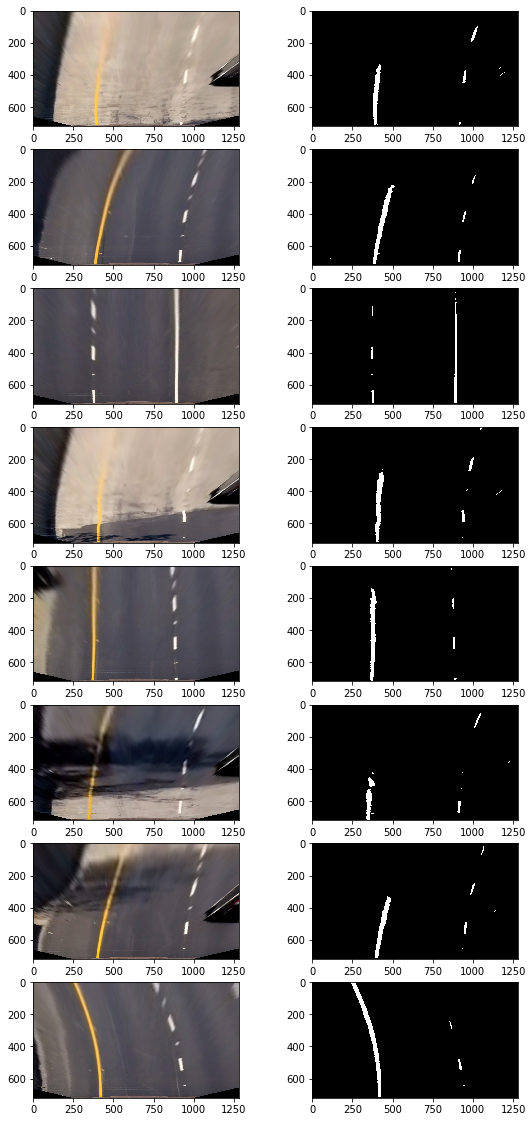

In [27]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

example_pip_out = np.copy(img)
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_undist = cal_undistort(img, objpoints, imgpoints)
    
    
    
    width = img.shape[1]  #( 960, 540 )
    height = img.shape[0]
    
    arr_vertices = np.array([[[width*0.451, height*0.625],\
                             [width*0.554,height*0.625],\
                             [width*1,height],\
                             [width*0.05,height]]],np.int32)
    
    img_bev = bird_eye_view(img_undist,arr_vertices)
    
    
    
    img_bin = pipeline(img_bev)
    axs[i].imshow(img_bev)
    axs[i].axis('on')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('on')
    i += 1
    
    example_main_out = img_undist
    example_pip_out = img_bin
    example_bev_out = img_bev

print('...')

## Find histogram peak

In [28]:
def hist(img):
   
    bottom_half = img[3*img.shape[0]//5:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    
    return histogram

# get left and right histogram max indices
def get_peak(hist,hist_peak):
    
    hist_peak = hist_peak.astype(np.int)
    
    left_hist = hist[:hist.shape[0]//2]
    right_hist = hist[hist.shape[0]//2:] 
    
    if(np.count_nonzero(left_hist) > 0):
        hist_peak[0] = np.argmax(left_hist)
    
    if(np.count_nonzero(right_hist) > 0):
        hist_peak[1] = np.argmax(right_hist) + hist.shape[0]//2
        
    return hist_peak

...


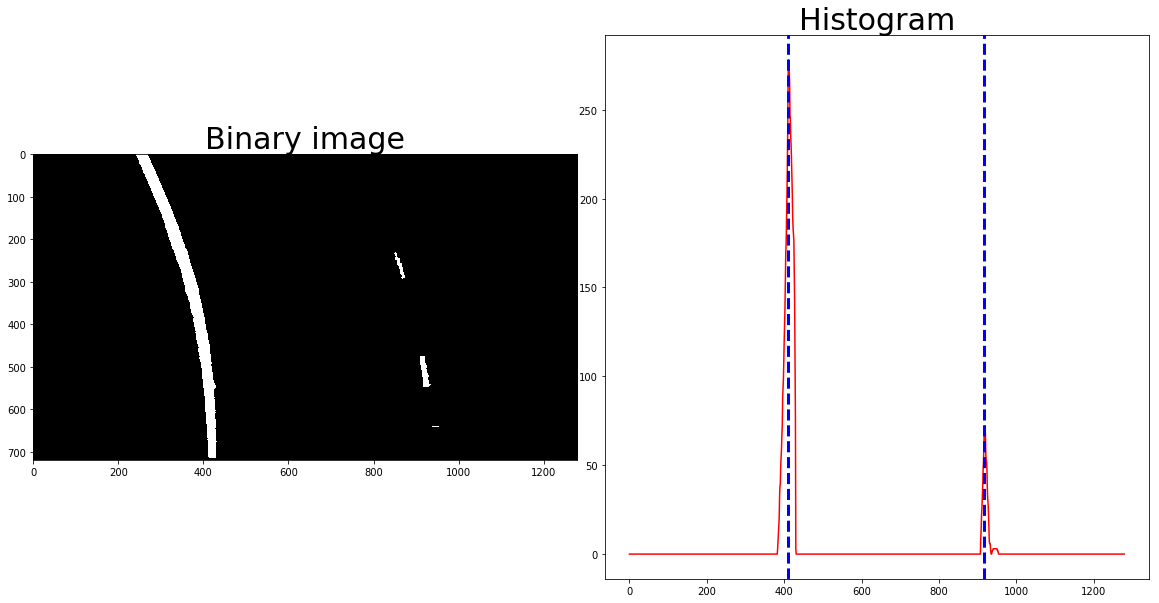

In [29]:
hist_peak = np.zeros(2,np.int)

histogram = hist(example_pip_out)
hist_peak = get_peak(histogram , hist_peak)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(example_pip_out,cmap='gray')
ax1.set_title('Binary image', fontsize=30)
ax2.plot(histogram/255,color='r')
# add the vertical lines
ax2.axvline(hist_peak[0], color='b', linestyle='--', linewidth=3)
ax2.axvline(hist_peak[1], color='b', linestyle='--', linewidth=3)
ax2.set_title('Histogram', fontsize=30)    



print('...')

## Polyfit by sliding window 

In [30]:
def search_in_sliding_window(threshold_img, left_fit, right_fit, hist_peak, nwindows = 10,margin= 100,minpix = 50):  # get Sliding Windows and Fit a Polynomial 
    
    window_height = np.int(threshold_img.shape[0]//nwindows)
    
    nonzero = threshold_img.nonzero()
    # nonzero pixels' indices
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    
    leftx_current = hist_peak[0]
    rightx_current = hist_peak[1] # max_index 저장
    
  
    out_img = np.dstack((threshold_img, threshold_img, threshold_img))
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        
        win_y_low = threshold_img.shape[0] - (window+1)*window_height
        win_y_high = threshold_img.shape[0] - (window)*window_height
        win_x_left_low = leftx_current - margin
        win_x_left_high = leftx_current + margin
        win_x_right_low = rightx_current - margin
        win_x_right_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_x_left_low,win_y_low),
        (win_x_left_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_x_right_low,win_y_low),
        (win_x_right_high,win_y_high),(0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        left_win_inds = ((nonzeroy<win_y_high)&(nonzeroy>win_y_low)& \
                         (nonzerox<win_x_left_high)&(nonzerox>win_x_left_low)).nonzero()[0]
        right_win_inds = ((nonzeroy<win_y_high)&(nonzeroy>win_y_low)& \
                          (nonzerox<win_x_right_high)&(nonzerox>win_x_right_low)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(left_win_inds)
        right_lane_inds.append(right_win_inds)
        
        ###  found > minpix pixels, recenter next window ###
        if len(left_win_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_win_inds]))
        if len(right_win_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_win_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        pass
        
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        pass
    ###ERROR occur if no lane found

    return leftx, lefty, rightx, righty,left_fit,right_fit, out_img

### visualizing sliding window

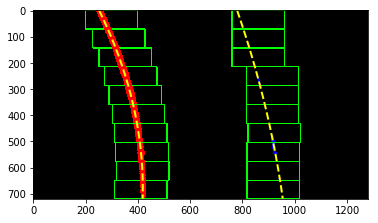

In [31]:
left_fit = np.zeros(3)
right_fit = np.zeros(3)

leftx, lefty, rightx, righty, left_fit, right_fit, out_img = search_in_sliding_window(example_pip_out,left_fit, right_fit ,hist_peak)
ploty = np.linspace(0, example_pip_out.shape[0]-1, example_pip_out.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth=2 , linestyle = "--")
plt.plot(right_fitx, ploty, color='yellow', linewidth=2 , linestyle = "--")


In [32]:
# Define method to fit polynomial to binary image based upon a previous fit
# this assumes that the fit will not change significantly from one video frame to the next

def search_around_poly(binary_warped, margin,left_fit,right_fit):
   
    # Grab activated pixels return indices that have values
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds =((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #Fit new polynomials
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
   
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
   
    return leftx, lefty, rightx, righty,left_fit,right_fit, result
    

### visualize polynomial based upon a previous fit

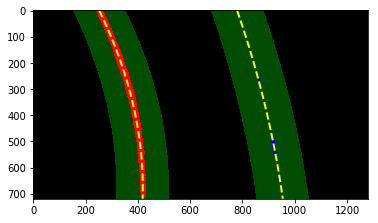

In [33]:
leftx, lefty, rightx, righty, left_fit, right_fit, result_bev = search_around_poly(example_pip_out, 100 ,left_fit,right_fit)

ploty = np.linspace(0, example_pip_out.shape[0]-1, example_pip_out.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

result_bev[lefty, leftx] = [255, 0, 0]
result_bev[righty, rightx] = [0, 0, 255]

plt.imshow(result_bev)
plt.plot(left_fitx, ploty, color='yellow', linewidth=2 , linestyle = "--")
plt.plot(right_fitx, ploty, color='yellow', linewidth=2, linestyle = "--")

### Getting polynomial pipline

In [34]:
def get_poly(threshold_img, hist_peak, n_window, margin, minpix,left_fit,right_fit,flag):
    
    #if ((np.array_equal(left_fit,np.zeros_like(left_fit)) | np.array_equal(right_fit,np.zeros_like(right_fit))) ):
    if (flag == True):
        leftx, lefty, rightx, righty, left_fit, right_fit, out_img = search_in_sliding_window(threshold_img,left_fit,right_fit ,hist_peak, n_window, margin, minpix)
        
    else:
        leftx, lefty, rightx, righty, left_fit,right_fit, out_img = search_around_poly(threshold_img, margin,left_fit,right_fit)
    
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    ploty = np.linspace(0, threshold_img.shape[0]-1, threshold_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty        
    
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return ploty,left_fit,right_fit, out_img
    

### Radius of Curvature and Distance from Lane Center Calculation

In [35]:
def measure_curvature_pixels(ploty, left_fit , right_fit, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    left_fit_cr = [xm_per_pix*left_fit[0]/(ym_per_pix**2),xm_per_pix*left_fit[1]/ym_per_pix,xm_per_pix*left_fit[2]]
    right_fit_cr = [xm_per_pix*right_fit[0]/(ym_per_pix**2),xm_per_pix*right_fit[1]/ym_per_pix,xm_per_pix*right_fit[2]]
    
    ### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5)/(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5)/(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


def cal_center(img,hist_peak,xm_per_pix= 3.7/700):
    
    center = img.shape[1]/2
    
    dif = (center - np.mean(hist_peak, axis=0))*xm_per_pix
    
    return dif

#### Calculate curvature radius and distance from center for example image

In [36]:
left_curverad,right_curverad = measure_curvature_pixels(ploty, left_fit , right_fit)
center_dif = cal_center(img,hist_peak)

print('Radius of curvature for example:', left_curverad, 'm,', right_curverad, 'm')
print('Distance from lane center for example:', center_dif, 'm')

Radius of curvature for example: -455.401192089 m, -1138.16159101 m
Distance from lane center for example: -0.126857142857 m


## Fill color between lanes

In [37]:
def print_lane(img, ploty, left_fit, right_fit):
    
    out_img = np.dstack((img, img, img))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    line_pts = np.hstack((line_window1, line_window2))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    window_img = np.zeros_like(out_img)
    
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    
    cv2.polylines(window_img, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=10)
    cv2.polylines(window_img, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=10)
    result = window_img
    
    return result

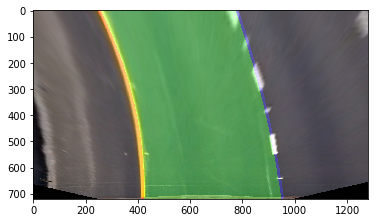

In [38]:
lane_filled = print_lane(example_pip_out, ploty, left_fit, right_fit)
result = cv2.addWeighted(lane_filled, 0.3, example_bev_out, 1, 0)
plt.imshow(result)

In [39]:
def re_bird_eye_view(img_original, img_bird , arr_vertices):

    dst = np.float32([[arr_vertices[0,0,0]-50,arr_vertices[0,0,1]],\
                      [arr_vertices[0,1,0]+50,arr_vertices[0,1,1]],\
                      [arr_vertices[0,3,0]-500,arr_vertices[0,3,1]],\
                      [arr_vertices[0,2,0]+500,arr_vertices[0,2,1]]])
    
    src = np.float32([[0.,0.],[width,0.],[0.,height],[width,height]])
        
    img_size = (img.shape[1], img.shape[0])
    
    minv = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img_bird, minv, img_size,flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img_original, 1, warped, 0.4, 0)
    
    return result

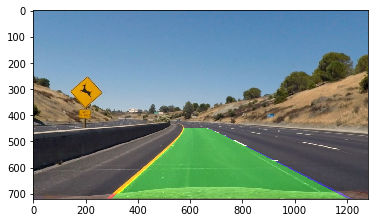

In [40]:
re_bird = re_bird_eye_view(example_main_out,lane_filled,arr_vertices)
plt.imshow(re_bird)

In [41]:
def print_info(img,bev_img,left_curverad, right_curverad, center_dif):
    new_img = np.copy(img)
    avg_curvature = (left_curverad+right_curverad)*0.5
    
    average_rad_string = "Radius of Curvature: %.2f m , %.2f m" % (left_curverad, right_curverad)
    
    if center_dif > 0:
        direction = 'right'
    elif center_dif < 0:
        direction = 'left'
    else:
        direction = 'center'
    abs_center_dist = abs(center_dif)
    lane_center_string = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    
    cv2.putText(new_img, average_rad_string, (30, 50), cv2.FONT_HERSHEY_TRIPLEX, 1, (0,255,0), thickness=2)
    cv2.putText(new_img, lane_center_string, (30, 100), cv2.FONT_HERSHEY_TRIPLEX, 1, (0,255,0), thickness=2)
    
    
    # overlay bird_eye_view binary image on the right top of the image
    
    (h, w) = img.shape[:2]
    
    dst = cv2.resize(bev_img, dsize=(0, 0), fx=0.2, fy=0.2 , interpolation=cv2.INTER_AREA)
    (h_, w_) = dst.shape[:2]

    
    overlay = np.zeros_like(img)
    overlay[:h_, w - w_:] = dst
    
    cv2.addWeighted(overlay, 1.0, new_img, 1.0, 0, new_img)
    
    
    return new_img
    

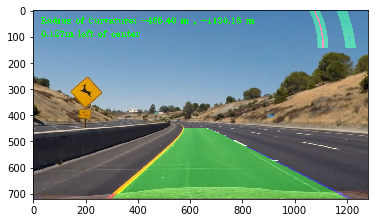

In [42]:
result = print_info(re_bird, result_bev ,left_curverad, right_curverad, center_dif)
plt.imshow(result)

## Test on Videos


In [43]:
def process_image(image):
    
    global count
    global left_fit
    global right_fit
    global hist_peak
    
    img_undist = cal_undistort(image, objpoints, imgpoints)
    
    
    width = img_undist.shape[1]  
    height = img_undist.shape[0]
    
    arr_vertices = np.array([[[width*0.451, height*0.625],\
                             [width*0.554,height*0.625],\
                             [width*1,height],\
                             [width*0.05,height]]],np.int32)
   
    
    img_bev = bird_eye_view(img_undist, arr_vertices)
    img_threshold = pipeline(img_bev)
    img_roi = region_of_interest(img_threshold)
    
    hist_peak = get_peak(hist(img_roi/255),hist_peak)
        
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    #### noise flitering section  ####
    if(left_fit[0]*right_fit[0] < 0):  
        noise_flag = True
    elif((np.array_equal(left_fit, right_fit) and (count != 0))):
        noise_flag = True
    elif(left_fit[2]>right_fit[2]):
        noise_flag = True
    else:
        noise_flag = False

    ##################################
   
    if(count == 0):
        left_fit = np.zeros(3)
        right_fit = np.zeros(3)
        # Only for the first frame: Run window based lane search approach
        ploty, left_fit, right_fit, img_poly = get_poly(img_threshold,hist_peak,nwindows,margin,minpix,left_fit,right_fit,flag = True)       
        count+=1
      
    elif(noise_flag == True):
        ploty, left_fit, right_fit, img_poly = get_poly(img_threshold,hist_peak,nwindows,margin,minpix,left_fit,right_fit,flag = True)       
        noise_flag == False
        
    else:
        # Logic to find region of interest from second frame onwards        
        ploty,left_fit, right_fit, img_poly = get_poly(img_threshold,hist_peak,nwindows,margin,minpix,left_fit,right_fit,flag = False)
       
    
    img_lane_printed = print_lane(img_threshold, ploty, left_fit, right_fit)
    
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit,ym_per_pix,xm_per_pix)
    
    img_re_bev = re_bird_eye_view(img_undist,img_lane_printed,arr_vertices)
    
    result = print_info(img_re_bev,img_poly,left_curverad, right_curverad,cal_center(img_undist,hist_peak,xm_per_pix))
    

    return  result

In [44]:
count = 0
hist_peak = np.zeros(2)

white_output = 'output_videos/project_video_s.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(40,44)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_s.mp4
[MoviePy] Writing video output_videos/project_video_s.mp4


100%|█████████▉| 1260/1261 [36:27<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_s.mp4 

CPU times: user 33min 59s, sys: 3.28 s, total: 34min 2s
Wall time: 36min 30s


In [45]:
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
  
</video>
""".format(white_output))

In [46]:
count = 0
hist_peak = np.zeros(2)

challenge_video  = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/challenge_video.mp4").subclip(0,3)
clip1 = VideoFileClip("test_videos/challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_video , audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [14:19<00:00,  1.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 13min 10s, sys: 15.8 s, total: 13min 26s
Wall time: 14min 21s


In [47]:
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(challenge_video ))

In [ ]:
count = 0

harder_challenge_video  = 'output_videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4").subclip(1,5)
##clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_video , audio=False)


[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


 33%|███▎      | 162/485 [04:42<09:29,  1.76s/it]

In [ ]:

HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video))

In [ ]:

os.listdir("test_images/")

In [ ]:
count = 0
for i in os.listdir('test_images/'):
    path = 'test_images/'+i 

    img_color = mpimg.imread(path)

    img_undist = cal_undistort(img_color, objpoints, imgpoints)
    
    
    width = img_color.shape[1]  #( 960, 540 )
    height = img_color.shape[0]
    
    arr_vertices = np.array([[[width*0.451, height*0.625],\
                             [width*0.554,height*0.625],\
                             [width*1,height],\
                             [width*0.05,height]]],np.int32)
    
#     img_bev = bird_eye_view(img_roi,arr_vertices)
  
    img_bev = bird_eye_view(img_undist,arr_vertices)
    img_threshold = pipeline(img_bev)
    img_roi = region_of_interest(img_threshold,arr_vertices)

    
    histogram = hist(img_threshold/255)
      
    hist_peak = get_peak(histogram,hist_peak)
    
    plt.imshow(img_color)
    plt.show()
    plt.imshow(img_threshold)
    plt.show()
    
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    global count
    global left_fit
    global right_fit
    
#     left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#     right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    
    left_fit = np.zeros(3)
    right_fit = np.zeros(3)
    
    if(count == 0):
        # Only for the first frame: Run window based lane search approach
        left_fit = np.zeros(3)
        right_fit = np.zeros(3)
        
        ploty, left_fit, right_fit, img_poly = get_poly(img_threshold,hist_peak,nwindows,margin,minpix,left_fit,right_fit,None)       
        count+=1
       
    else:
        # Logic to find region of interest from second frame onwards        
        ploty,left_fit, right_fit, img_poly = get_poly(img_threshold,hist_peak,nwindows,margin,minpix,left_fit,right_fit,None)
    
    img_lane_printed = print_lane(img_threshold, ploty, left_fit, right_fit)
    
    
    
    
    plt.plot(histogram)
    plt.show()
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit,ym_per_pix,xm_per_pix)
    
    plt.imshow(img_poly)
    plt.show()
    plt.imshow(img_lane_printed)
    plt.show()
    print(100*cal_center(img_undist,hist_peak,xm_per_pix))
    print(measure_curvature_pixels(ploty, left_fit, right_fit,ym_per_pix,xm_per_pix ))
    print(left_fit)
    